# Power law example

The power in frequency bins is simulated with a power law.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from jax import jit
import jax.numpy as jnp
import jax.scipy as js
import jax.random as jr

import numpyro
import numpyro.distributions as dist

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from simulate_data import get_rho

import torch
import zuko

## Load data

The power in each frequency bin is modeled according to the power law,

\begin{equation}
    \vec{\rho}\,(A, \gamma) = A\,\bigg(\frac{\vec{f}}{f_\text{ref}}\bigg)^{-\gamma}\;.
\end{equation}

In [3]:
# load data from dictionary and convert to jax.numpy objects
data_dict = np.load('data.npz')
times = jnp.array(data_dict['times'])
freqs = jnp.array(data_dict['freqs'])
data = jnp.array(data_dict['data'])
signal_inj = jnp.array(data_dict['signal_inj'])
hypers_inj = jnp.array(data_dict['hypers_inj'])
sigma_inj = jnp.float32(data_dict['sigma_inj'])
a_inj = jnp.array(data_dict['a_inj'])
F = jnp.array(data_dict['F'])

# derived objects
rho_inj = get_rho(*hypers_inj)
logrho_inj = jnp.log10(rho_inj[::2])
Na = a_inj.shape[0]
Nf = Na // 2
Nt = times.shape[0]

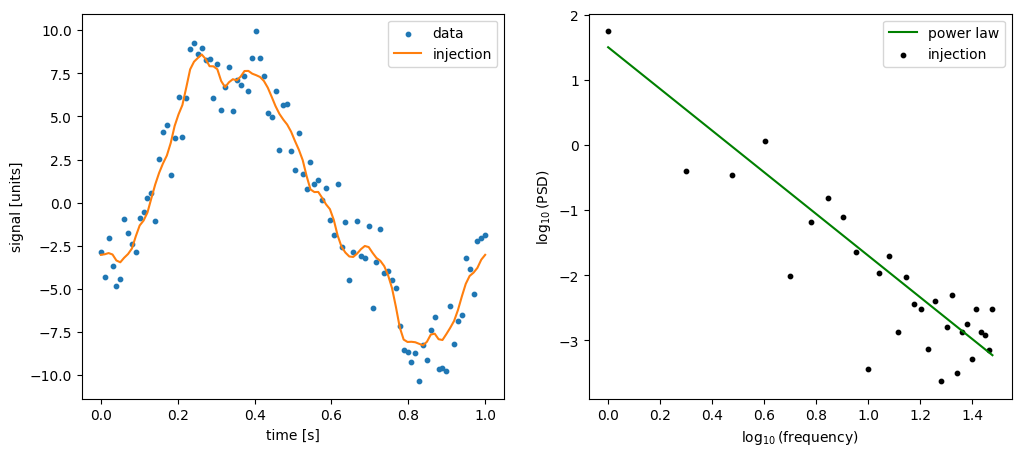

In [4]:
# plot data and injection
# time-domain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(times, data, color='C0', s=10, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()

# frequency-domain
plt.subplot(1, 2, 2)
plt.plot(jnp.log10(freqs), jnp.log10(2 * rho_inj[::2]), color='green', label='power law')
plt.scatter(jnp.log10(freqs), jnp.log10(a_inj[::2]**2. + a_inj[1::2]**2.), color='k', s=10, label='injection')
plt.xlabel(r'$\log_{10}$(frequency)')
plt.ylabel(r'$\log_{10}$(PSD)')
plt.legend()
plt.show()

## Free spectral model

In [5]:
# parameter bounds
logrho_mins = jnp.array([-10.] * Nf)
logrho_maxs = jnp.array([10.] * Nf)
sigma_min = 0.
sigma_max = 10.
a_min = -100.
a_max = 100.
x_mins = jnp.concatenate((logrho_mins, jnp.array([sigma_min]), jnp.array([a_min] * Na)))
x_maxs = jnp.concatenate((logrho_maxs, jnp.array([sigma_max]), jnp.array([a_max] * Na)))

# parameter labels
logrho_labels = np.array([rf'$\log_{{{10}}} \rho_{{{i}}}$' for i in np.arange(1, Nf + 1)])
sigma_label = r'$\sigma$'
a_labels = np.array([rf'$a_{{{i // 2}}}$' if i % 2 == 0 else rf'$b_{{{i // 2}}}$'
                     for i in np.arange(2, 2 + Na)])
x_labels = np.concatenate((logrho_labels, np.array([sigma_label]), a_labels))

# injected parameters
x_inj = jnp.concatenate((logrho_inj, jnp.array([sigma_inj]), a_inj))
ndim = x_inj.shape[0]

In [6]:
# likelihood
@jit
def lnlike(sigma, a):
    # residuals
    residuals = data - F @ a
    # likelihood calculation
    return -0.5 * jnp.sum(residuals**2.) / sigma**2. - Nt * jnp.log(sigma)

## Sample hierarchical model with HMC

In [7]:
def sampling_model():
    # uniform prior on hyper-parameters
    logrhos = numpyro.sample('logrhos', dist.Uniform(logrho_mins, logrho_maxs))
    sigma = numpyro.sample('sigma', dist.Uniform(sigma_min, sigma_max))
    # prior on Fourier coefficients
    # a = numpyro.sample('a', dist.Normal(jnp.zeros(Na), jnp.sqrt(get_rho(*hypers))))
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([Na]))
    a = numpyro.deterministic('a', a_standard * jnp.repeat(jnp.sqrt(10. ** logrhos), 2))
    # likelihood
    numpyro.factor('ln_likelihood', lnlike(sigma, a))

nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(5e3),
                          num_samples=int(1e4))
mcmc.run(jr.key(150914))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['logrhos'],
                          samples_dict['sigma'][:, None],
                          samples_dict['a']), axis=1)

sample: 100%|██████████| 15000/15000 [00:24<00:00, 618.61it/s, 127 steps of size 2.38e-02. acc. prob=0.94]


## Post-processing

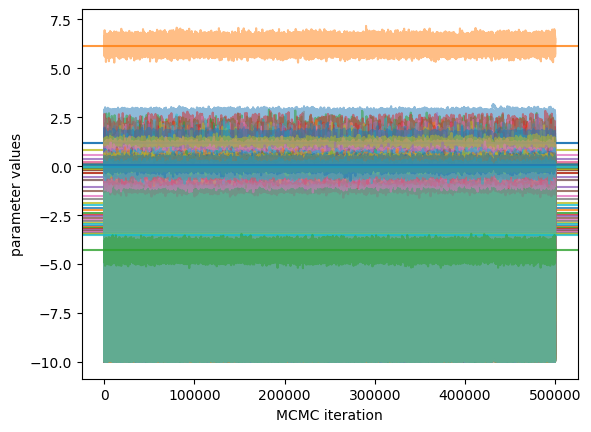

In [8]:
# trace plot
for i in range(ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

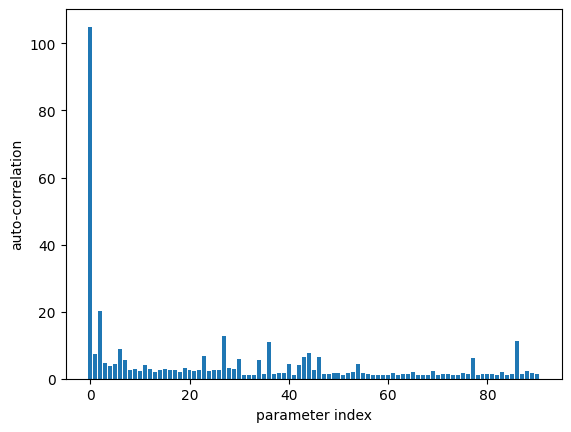

In [9]:
# plot auto-correlations of paramters
plt.bar(np.arange(ndim), np.array([integrated_time(samples[200_000:, i])[0] for i in range(ndim)]))
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

Parameter $\log_{10} \rho_{2}$ in chain HMC is not constrained


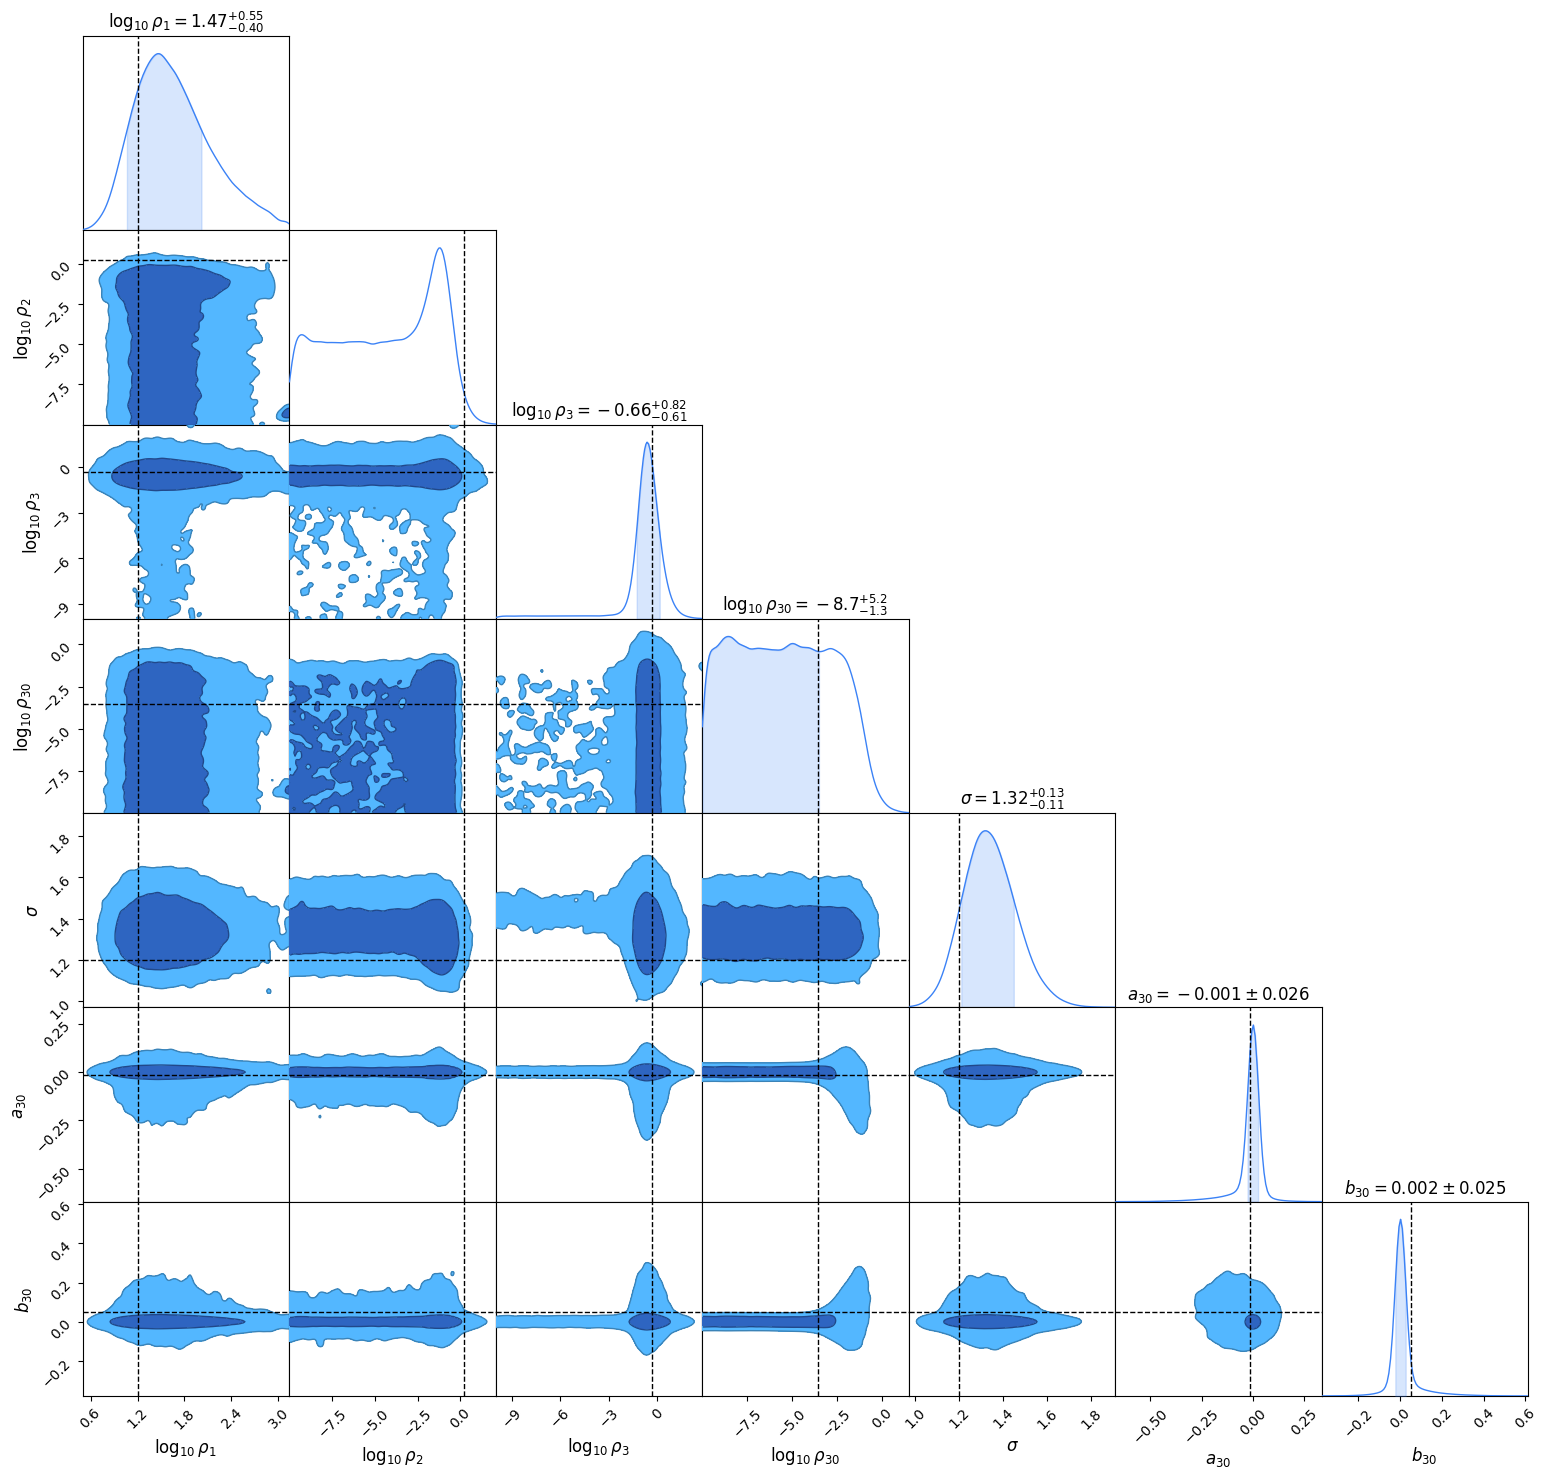

In [10]:
# posterior samples
ndxs = np.concatenate((np.r_[:3], np.r_[Nf - 1: Nf + 1], np.r_[-2:0]))
df = pd.DataFrame(samples[::5], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_inj)}))
fig = c.plotter.plot()

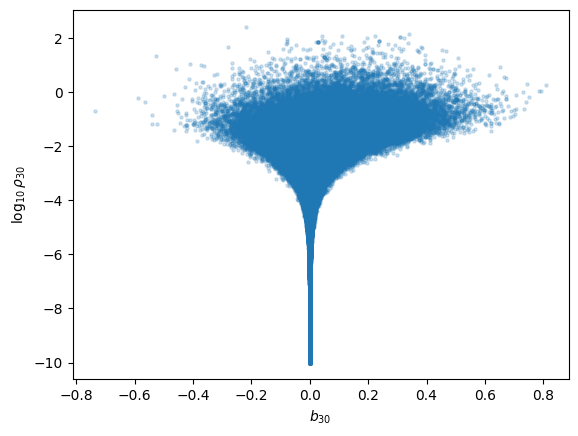

In [11]:
# visualize Neal's funnel
plt.scatter(samples[:, -1], samples[:, Nf - 1], color='C0', alpha=0.2, s=5)
plt.xlabel(x_labels[-1])
plt.ylabel(x_labels[Nf - 1])
plt.show()

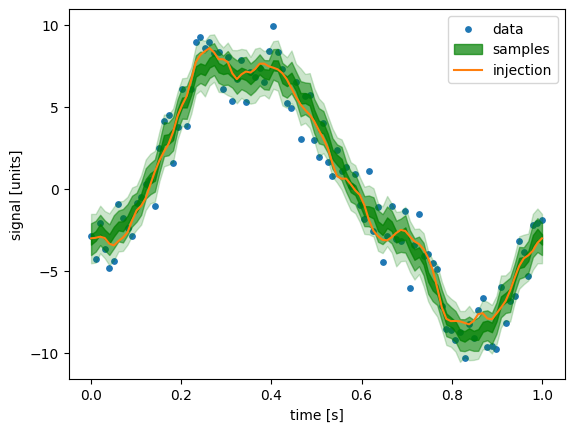

In [12]:
# signal recovery in time-domain (Bayesogram)
fair_draws_ndxs = jr.choice(jr.key(11), samples.shape[0], (1000,))
signals = np.array([F @ a for a in samples[fair_draws_ndxs, Nf + 1:]])

plt.scatter(times, data, color='C0', s=15, label='data')
plt.fill_between(times, np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
                 color='green', alpha=0.2)
plt.fill_between(times, np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
                 color='green', alpha=0.5)
plt.fill_between(times, np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
                 color='green', alpha=0.7, label='samples')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

In [13]:
# only learn distribution on free power (not Fourier coefficients)
free_spectral_samples = torch.tensor(samples[::1, :Nf])

In [14]:
# functions to "normalized" and "unnormalize" samples
# normalized samples have are centered on zero and have symmetric bounds
B = 4
max_val = torch.max(free_spectral_samples, axis=0).values
min_val = torch.min(free_spectral_samples, axis=0).values
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val) / h

def unnormalize(sample):
    return sample * h / B + mean_val

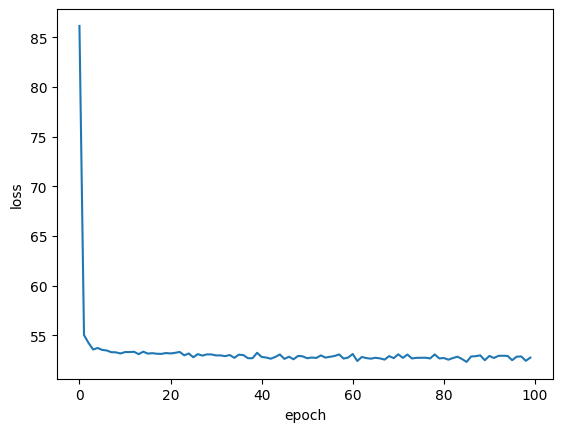

In [16]:
# train normalzing flow
torch.set_default_dtype(torch.float64)

# define flow
free_spectral_flow = zuko.flows.spline.NSF(features=Nf,
                                           context=0,
                                           bins=8,
                                           passes=2,
                                           hidden_features=[512] * 4)

# data is normalized free spectral samples
normalized_samples = normalize(free_spectral_samples).to(torch.float64)

# attributes for training
batch_size = 512
optimizer = torch.optim.Adam(free_spectral_flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(1e3)

# train flow
for epoch in range(num_epoch):

    # randomly draw from data to train
    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    # compute loss function
    loss = -free_spectral_flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    # update progress and print loss function
    if epoch % 10 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%  loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
# sample from flow and unnormalize samples
flow_samples = unnormalize(free_spectral_flow().sample((int(1e5),)))

Parameter $\log_{10} \rho_{2}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{2}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{5}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{5}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{6}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{6}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{7}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{7}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{8}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{8}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{9}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{9}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{10}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{10}$ in chain normalizing flow is not constrained


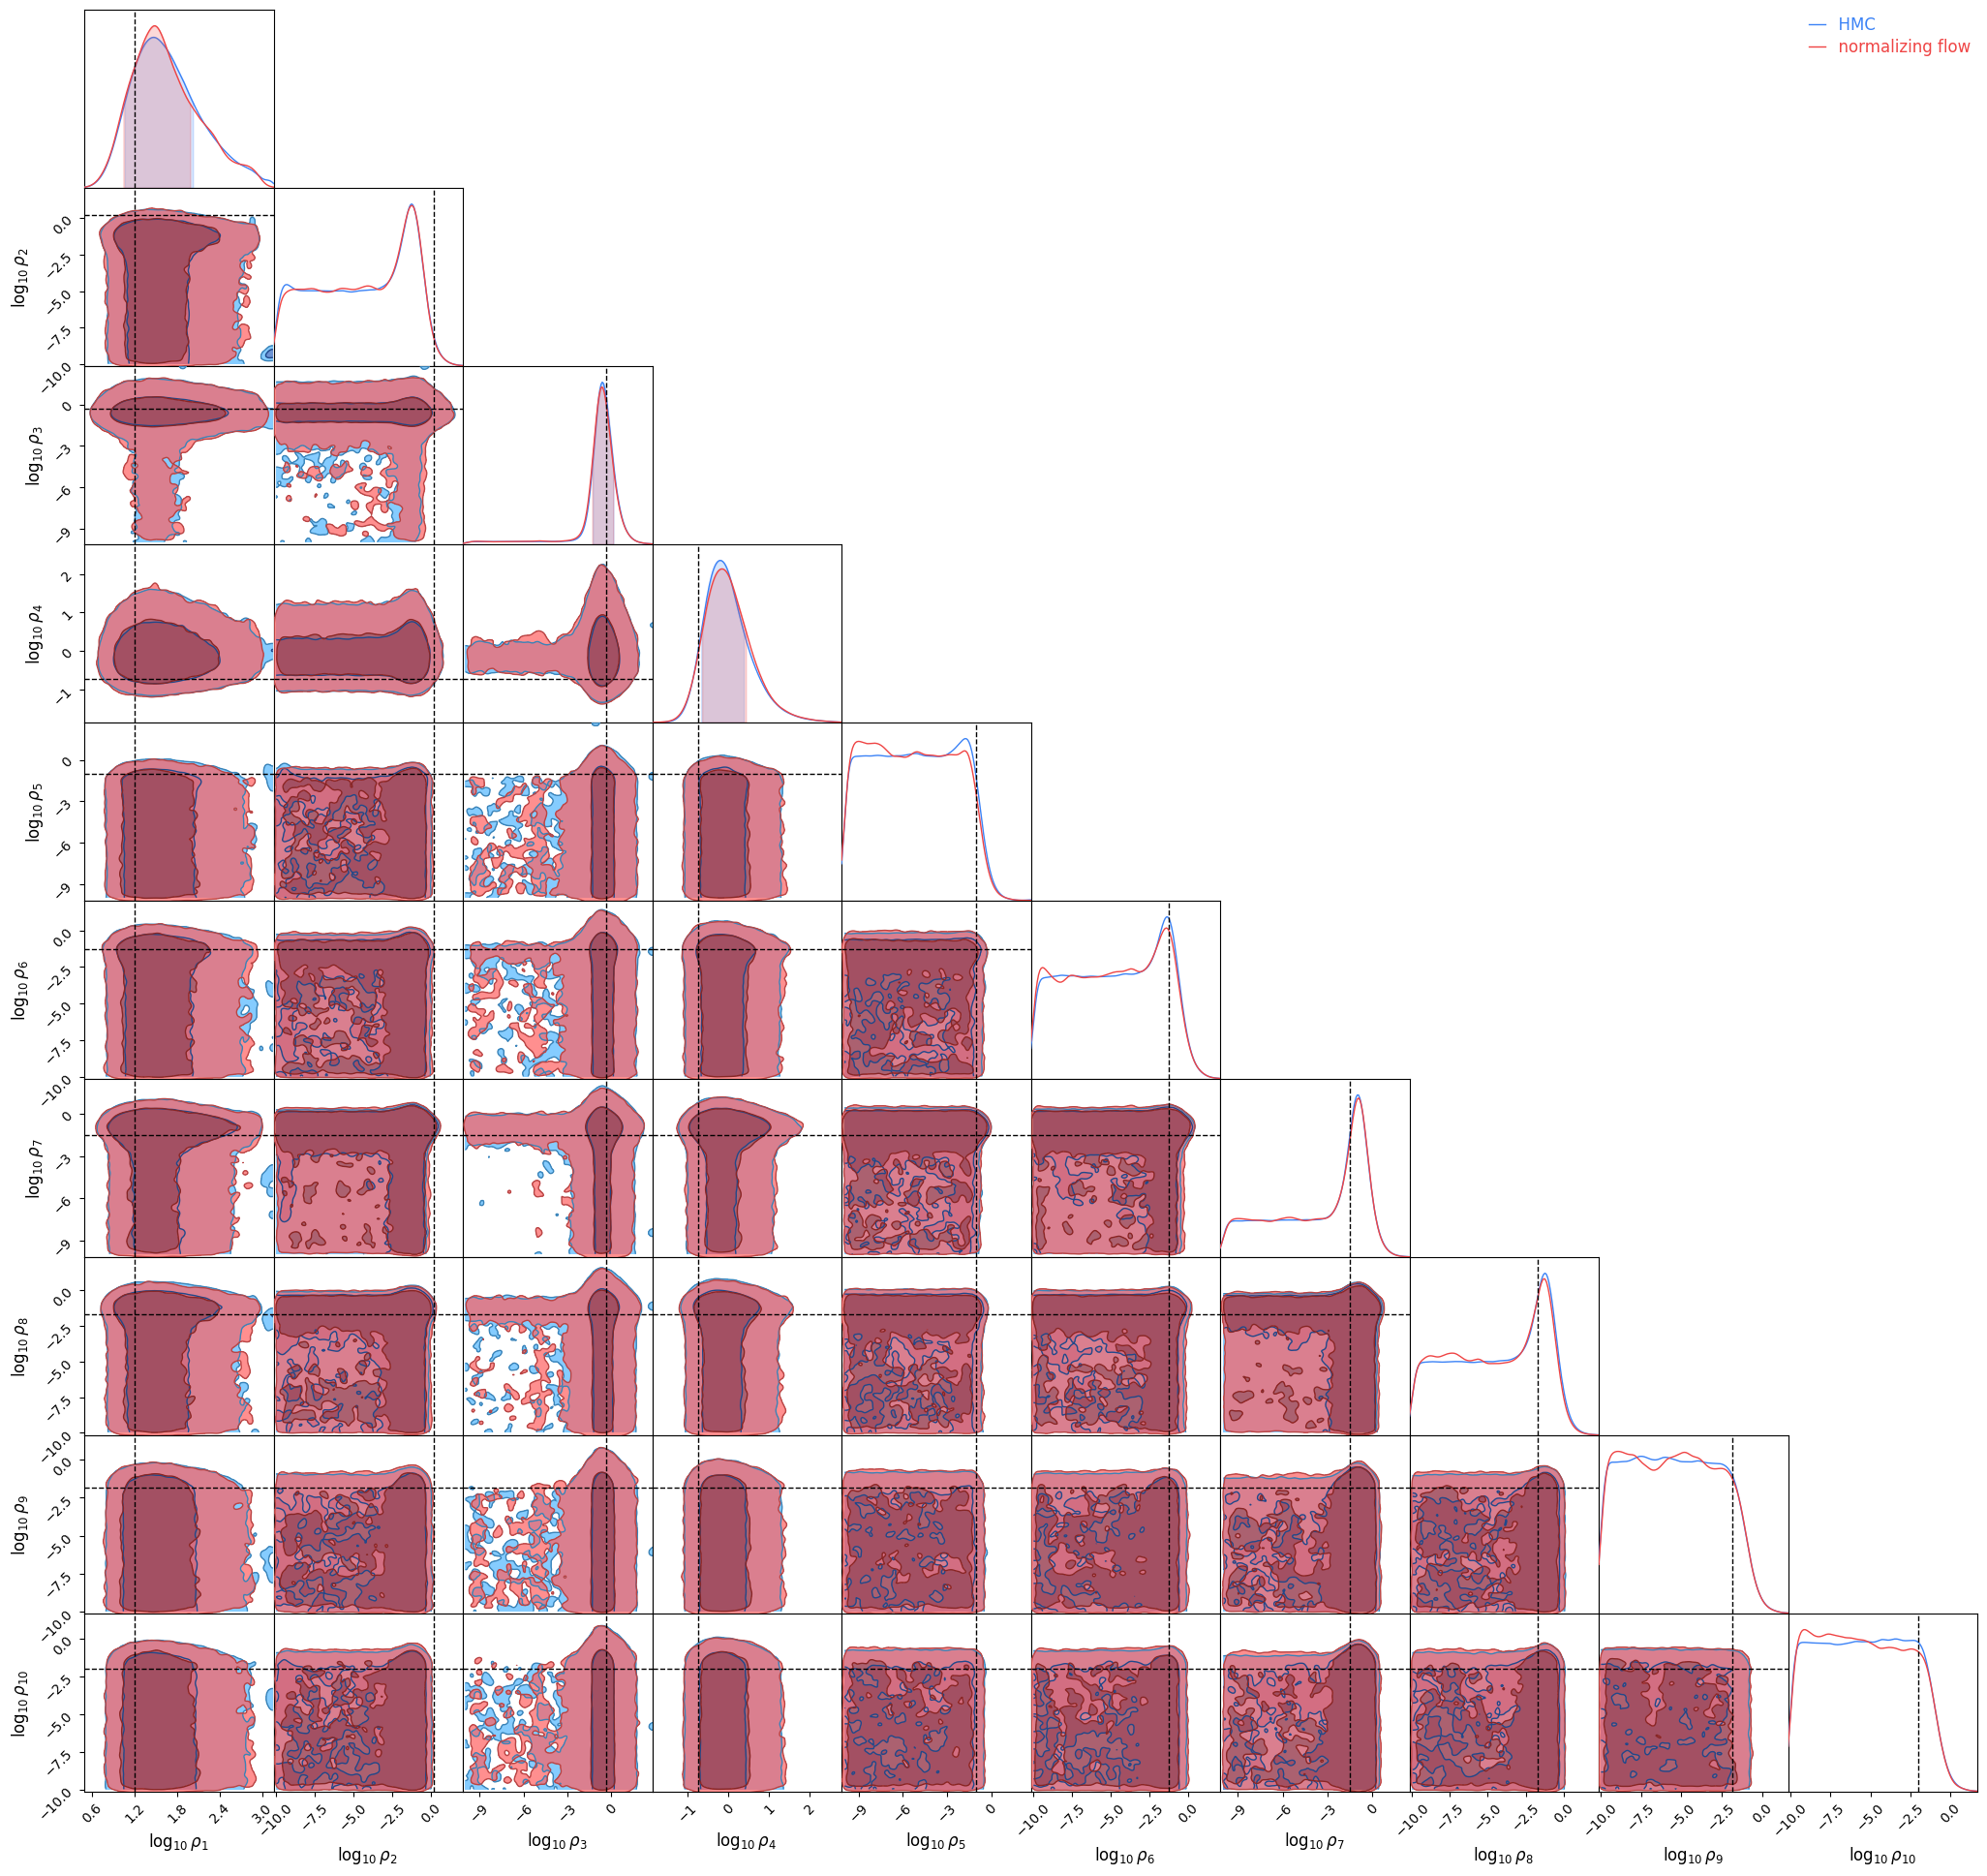

In [18]:
# plot original and flow samples
ndxs = np.r_[:10]
df_hmc = pd.DataFrame(free_spectral_samples, columns=logrho_labels)
df_flow = pd.DataFrame(flow_samples, columns=logrho_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, ndxs], name='HMC'))
c.add_chain(Chain(samples=df_flow.iloc[:, ndxs], name='normalizing flow', color='red'))
c.add_truth(Truth(location={name: val for name, val in zip(logrho_labels, logrho_inj)}))
fig = c.plotter.plot()

In [19]:
# power law covariance in torch
freqs_torch = torch.tensor(freqs / freqs[0], dtype=torch.float64)
def get_rho_diag_torch(hyper_params):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return Amp * freqs_torch ** (-gamma)

# vectorized covariance for multiple inputs
def vec_get_rho_diag_torch(hyper_params):
    logAmp, gamma = hyper_params.T  # shape (N,)
    Amp = 10. ** logAmp
    return Amp[:, None] * freqs_torch[None, :] ** (-gamma[:, None])

In [20]:
# define flow once outside of likelihood
flow_fs = free_spectral_flow()

# second stage likelihood (reparameterize with power law)
def second_stage_lnlike(x):
    log10rhos = torch.log10(get_rho_diag_torch(x))
    lnlike = flow_fs.log_prob(normalize(log10rhos))
    return lnlike

# vectorize likelihood for multiple inputs
def vec_second_stage_lnlike(x):
    log10rhos = torch.log10(vec_get_rho_diag_torch(x))
    lnlike = flow_fs.log_prob(normalize(log10rhos))
    return lnlike

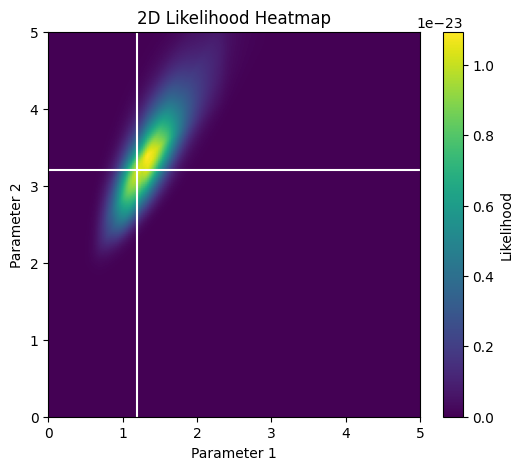

In [21]:
def plot_likelihood_heatmap(likelihood_fn, bounds, n=100, m=100):
    """
    Plot a 2D likelihood heatmap.

    Parameters
    ----------
    likelihood_fn : callable
        Function that accepts a tensor of shape (N, 2) and returns (N,) likelihood values.
    bounds : tuple
        ((x_min, x_max), (y_min, y_max)) bounds for the two parameters.
    n, m : int
        Number of grid points along x and y.
    """
    (x_min, x_max), (y_min, y_max) = bounds

    # Create grid
    x = torch.linspace(x_min, x_max, n)
    y = torch.linspace(y_min, y_max, m)
    X, Y = torch.meshgrid(x, y, indexing="xy")

    # Flatten grid for likelihood evaluation
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)

    # Evaluate likelihood
    Z = likelihood_fn(points)  # shape (n*m,)
    Z = torch.exp(Z.reshape(n, m))

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    im = plt.imshow(Z.detach().numpy(), origin='lower',
                    extent=(x_min, x_max, y_min, y_max),
                    aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Likelihood')
    plt.axvline(hypers_inj[0], color='white')
    plt.axhline(hypers_inj[1], color='white')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.title('2D Likelihood Heatmap')
    plt.show()
    return X.detach().numpy(), Y.detach().numpy(), Z.detach().numpy()

X, Y, Z = plot_likelihood_heatmap(vec_second_stage_lnlike, ((0, 5), (0, 5)), 200, 200)

In [25]:
import pyro
from pyro import distributions as pyro_dist
from pyro.infer.autoguide import init_to_value

# do HMC NUTS with Pyro
hyper_mins = torch.tensor([0., 2.])
hyper_maxs = torch.tensor([5., 7.])

def second_stage_sampling_model():
    hypers = pyro.sample('hypers', pyro_dist.Uniform(hyper_mins, hyper_maxs))
    pyro.factor('lnlike', second_stage_lnlike(hypers))

pyro_nuts_kernel = pyro.infer.NUTS(model=second_stage_sampling_model,
                                   full_mass=True,
                                   init_strategy=init_to_value(values={'hypers': torch.tensor([1.2, 3.2])}))
pyro_mcmc = pyro.infer.MCMC(kernel=pyro_nuts_kernel,
                            warmup_steps=500,
                            num_samples=int(5e3))
pyro_mcmc.run()
hyper_samples_dict = pyro_mcmc.get_samples()
hyper_samples_free = hyper_samples_dict['hypers']

Sample: 100%|██████████| 5500/5500 [03:15, 28.10it/s, step size=5.77e-01, acc. prob=0.911]


In [26]:
def sample_from_likelihood_grid(X, Y, Z, num_samples=1000, log_likelihood=False):
    """
    Draw samples from a 2D likelihood grid.

    Parameters
    ----------
    X, Y : 2D arrays
        Meshgrid arrays of parameter values (same shape as Z).
    Z : 2D array
        Likelihood values (can be unnormalized).
    num_samples : int
        Number of samples to draw.
    log_likelihood : bool
        If True, Z is in log-space.

    Returns
    -------
    samples : array of shape (num_samples, 2)
    """
    # Flatten
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = Z.flatten()

    if log_likelihood:
        z_flat = np.exp(z_flat - np.max(z_flat))  # prevent overflow

    # Normalize
    probs = z_flat / np.sum(z_flat)

    # Sample indices
    idx = np.random.choice(len(probs), size=num_samples, p=probs)

    # Map back to coordinates
    samples = np.column_stack([x_flat[idx], y_flat[idx]])
    return samples

hyper_samples_from_grid = sample_from_likelihood_grid(X, Y, Z, num_samples=int(1e4))

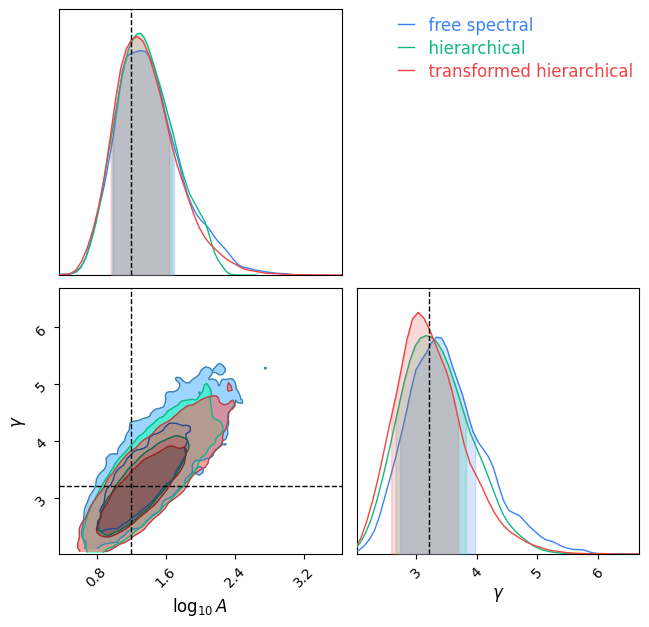

In [29]:
hyper_labels = [r'$\log_{{{10}}} A$', r'$\gamma$']
hypers_df = pd.DataFrame(hyper_samples_free, columns=hyper_labels)
# hypers_df = pd.DataFrame(hyper_samples_from_grid, columns=hyper_labels)
hyper_samples = pd.DataFrame(np.load('hypers.npy'), columns=hyper_labels)
standard_hyper_samples = pd.DataFrame(np.load('standard_hypers.npy'), columns=hyper_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=hypers_df, name='free spectral', smooth=1))
c.add_chain(Chain(samples=hyper_samples, name='hierarchical', smooth=1))
c.add_chain(Chain(samples=standard_hyper_samples, name='transformed hierarchical', smooth=1))
c.add_truth(Truth(location={name: val for name, val in zip(hyper_labels, data_dict['hypers_inj'])}))
fig = c.plotter.plot()

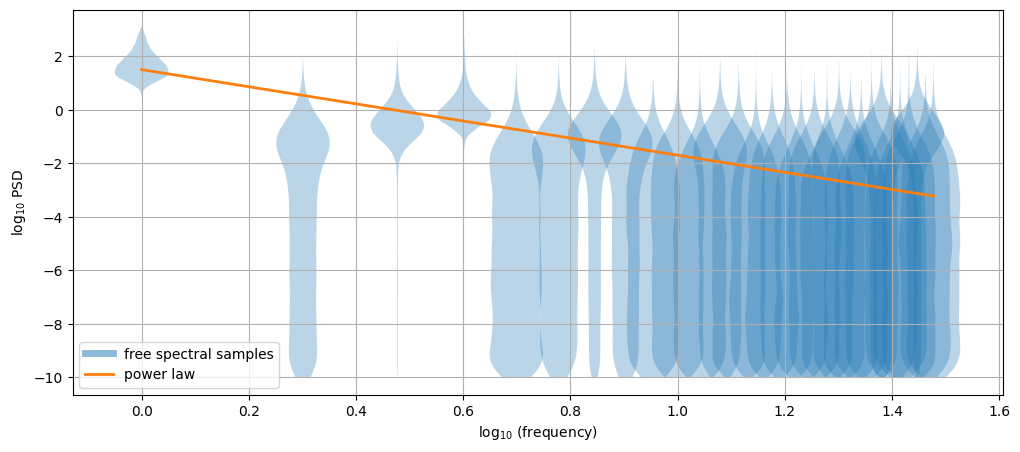

In [8]:
# violin plot
plt.figure(figsize=(12, 5))
plt.grid()
plt.violinplot(samples[:, :Nf], positions=jnp.log10(freqs), showextrema=False, widths=0.1)
# plt.scatter(jnp.log10(freqs), jnp.log10(a_inj[::2]**2. + a_inj[1::2]**2.), color='k', s=15, label='injection')
plt.plot([], [], color='C0', alpha=0.5, label='free spectral samples', lw=5)
# signals = np.array([np.log10(2. * get_rho(*hypers)[::2])
#                     for hypers in hyper_samples[jr.choice(jr.key(0), hyper_samples.shape[0], (1000,))]])
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
#                  color='green', alpha=0.2)
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
#                  color='green', alpha=0.5)
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
#                  color='green', alpha=0.7, label='samples from normalizing flow')
plt.plot(jnp.log10(freqs), jnp.log10(2. * rho_inj[::2]), color='C1', label='power law', lw=2)
plt.xlabel(r'$\log_{{{10}}}\,$(frequency)')
plt.ylabel(r'$\log_{{{10}}}\,$PSD')
plt.legend(loc='lower left')
plt.show()